In [2]:
import pandas as pd
import boto3, pymysql
from collections import Counter
from konlpy.tag import Okt

### 환경변수 불러오기
from config import *

In [3]:
def mysql_conn(HOST, USER, PASSWORD, DB, SQL, CHARSET="utf8"):
    conn = pymysql.connect(
        host=HOST, user=USER, password=PASSWORD, db=DB, charset=CHARSET
    )
    try:
        with conn.cursor() as cur:
            cur.execute(SQL)
            result = cur.fetchall()
            return result
    except:
        print("Not connected")

    finally:
        cur.close()
        conn.close()


def s3_conn(
    AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, AWS_DEFAULT_REGION, BUCKET_NAME, Key
):
    s3_client = boto3.client(
        "s3",
        aws_access_key_id=AWS_ACCESS_KEY_ID,
        aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
        region_name=AWS_DEFAULT_REGION,
    )
    contents = []

    for _ in Key:
        if _.startswith("news"):
            content = (
                s3_client.get_object(Bucket=BUCKET_NAME, Key=_)["Body"].read().decode()
            )
            contents.append(content)
        else:
            contents.append("None")
    return contents


def wc(data, num=100):
    json_data = []
    okt = Okt()
    noun = okt.nouns(data)
    counter = Counter(noun)
    top_num_noun = counter.most_common(num)
    for x, y in top_num_noun:
        json_data.append({"tag": x, "count": y})
    return json_data

In [4]:
columns = ["dailydate", "ticker", "name", "news_summary"]
SQL = f"select {', '.join(columns)} from daily_update"
result = mysql_conn(HOST, USER, PASSWORD, DB, SQL=SQL)
df = pd.DataFrame(result, columns=columns)
contents = s3_conn(
    AWS_ACCESS_KEY_ID,
    AWS_SECRET_ACCESS_KEY,
    AWS_DEFAULT_REGION,
    BUCKET_NAME,
    df["news_summary"],
)
df["contents"] = contents
json_data = wc(df["contents"].sum())

In [24]:
data = df["contents"].sum()

okt = Okt()
noun = okt.nouns(data)
counter = Counter(noun)
top_num_noun = counter.most_common(50)

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [141]:
df["contents"]

0      - 텍사스 주 유발데 초등학교 총기 난사 피해자 가족, 메타, 액티비전 블리자드, ...
1      마이크로소프트 임원 주식 매각으로 주가에 미미한 영향.\n\n 임원의 정기적인 재무...
2                                                   None
3      - 엘론 머스크의 인공지능(AI) 스타트업 xAI는 차세대 AI 챗봇 Grok에 동...
4      NVDA 주가는 회사의 인공지능(AI) 기술 성공에 힘입어 최근 실적 발표를 뛰어넘...
                             ...                        
225    * 티모바일이 유에스셀룰러의 무선 사업을 인수하여 2025년 중반에 거래가 완료될 ...
226    TMUS 임원의 주식 매도 소식으로 인해 회사 주가에 큰 영향은 없음.\n임원들은 ...
227    TMUS 이사가 329만 달러 상당의 자사 주식 2만 주를 매도했다.\n\n매도는 ...
228                                                 None
229                                                 None
Name: contents, Length: 230, dtype: object

In [142]:
text = df["contents"].apply(lambda x: okt.nouns(x)+["tf-idf"]).apply(lambda x: " ".join(x)).sum().split("tf-idf")


In [143]:
tfidf_vectorizer = TfidfVectorizer() # TF-IDF 객체 선언

In [145]:
tfidf_vectorizer.fit(text)

TfidfVectorizer()

In [146]:
dtm_name = tfidf_vectorizer.get_feature_names_out()

In [147]:
from scipy.sparse import csr_matrix

In [148]:
dtm_dense = tfidf_vectorizer.transform(text)

In [149]:
import networkx as nx
import numpy as np

In [211]:
edgelist = np.dot(dtm_dense.T, dtm_dense)

In [212]:
ngraph = nx.Graph(edgelist[:,:])

In [228]:
ngraph_map = dict(zip(ngraph.nodes(), dtm_name))

In [236]:
ngraph_map

{0: '가가',
 1: '가격',
 2: '가능성',
 3: '가장',
 4: '가족',
 5: '가지',
 6: '가치',
 7: '가치나',
 8: '가파른',
 9: '간접',
 10: '간주',
 11: '감성',
 12: '감소',
 13: '감행',
 14: '강세',
 15: '강화',
 16: '개발',
 17: '개선',
 18: '개인',
 19: '거듭',
 20: '거래',
 21: '거론',
 22: '거점',
 23: '게임',
 24: '견해',
 25: '결과',
 26: '결정',
 27: '결제',
 28: '경영',
 29: '경우',
 30: '경쟁',
 31: '경쟁력',
 32: '계획',
 33: '고가',
 34: '고객',
 35: '고성능',
 36: '공개',
 37: '공급',
 38: '공동',
 39: '공식',
 40: '공장',
 41: '과거',
 42: '과대',
 43: '과학',
 44: '관계',
 45: '관리',
 46: '관심',
 47: '관점',
 48: '관찰',
 49: '관할권',
 50: '교실',
 51: '교육',
 52: '교차점',
 53: '구간',
 54: '구글',
 55: '구당',
 56: '구매',
 57: '구별',
 58: '구성',
 59: '구성원',
 60: '구입',
 61: '구축',
 62: '국가',
 63: '국방',
 64: '국채',
 65: '국회',
 66: '규모',
 67: '규제',
 68: '규칙',
 69: '그래픽',
 70: '그룹',
 71: '근본',
 72: '글래스',
 73: '글로벌',
 74: '금속',
 75: '금액',
 76: '금요일',
 77: '금융',
 78: '금제',
 79: '급등',
 80: '급변',
 81: '긍정',
 82: '기관',
 83: '기대',
 84: '기록',
 85: '기반',
 86: '기술',
 87: '기업',
 88: '기여',
 89: '기조',
 90: '기회

In [230]:
ngraph_map[368], ngraph_map[465]

('엔비디아', '잠재')

In [262]:
a = ngraph.edges(data=True)

In [256]:
sorted(ngraph.edges(data=True), key=lambda x: x)

[(0, 0, {'weight': 0.02287344209529686}),
 (0, 1, {'weight': 0.019598608803687058}),
 (0, 3, {'weight': 0.010183113835848821}),
 (0, 5, {'weight': 0.01211201919059168}),
 (0, 6, {'weight': 0.01896965398594739}),
 (0, 20, {'weight': 0.025812732021348022}),
 (0, 21, {'weight': 0.01211201919059168}),
 (0, 23, {'weight': 0.010652858618845743}),
 (0, 25, {'weight': 0.011258464973589465}),
 (0, 28, {'weight': 0.012495560107565083}),
 (0, 30, {'weight': 0.009799304401843529}),
 (0, 32, {'weight': 0.009484826992973695}),
 (0, 48, {'weight': 0.011614977121707396}),
 (0, 66, {'weight': 0.009774828450735802}),
 (0, 71, {'weight': 0.01211201919059168}),
 (0, 81, {'weight': 0.009799304401843529}),
 (0, 88, {'weight': 0.010183113835848821}),
 (0, 101, {'weight': 0.04844807676236672}),
 (0, 112, {'weight': 0.016239248438437312}),
 (0, 122, {'weight': 0.010652858618845743}),
 (0, 127, {'weight': 0.021713045628434666}),
 (0, 140, {'weight': 0.012495560107565083}),
 (0, 142, {'weight': 0.012112019190591

In [232]:
ngraph.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

In [239]:
ngraph.nodes(data=True)

NodeDataView({0: {'a': '1'}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26: {}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32: {}, 33: {}, 34: {}, 35: {}, 36: {}, 37: {}, 38: {}, 39: {}, 40: {}, 41: {}, 42: {}, 43: {}, 44: {}, 45: {}, 46: {}, 47: {}, 48: {}, 49: {}, 50: {}, 51: {}, 52: {}, 53: {}, 54: {}, 55: {}, 56: {}, 57: {}, 58: {}, 59: {}, 60: {}, 61: {}, 62: {}, 63: {}, 64: {}, 65: {}, 66: {}, 67: {}, 68: {}, 69: {}, 70: {}, 71: {}, 72: {}, 73: {}, 74: {}, 75: {}, 76: {}, 77: {}, 78: {}, 79: {}, 80: {}, 81: {}, 82: {}, 83: {}, 84: {}, 85: {}, 86: {}, 87: {}, 88: {}, 89: {}, 90: {}, 91: {}, 92: {}, 93: {}, 94: {}, 95: {}, 96: {}, 97: {}, 98: {}, 99: {}, 100: {}, 101: {}, 102: {}, 103: {}, 104: {}, 105: {}, 106: {}, 107: {}, 108: {}, 109: {}, 110: {}, 111: {}, 112: {}, 113: {}, 114: {}, 115: {}, 116: {}, 117: {}, 118: {}, 119: {}, 120: {},

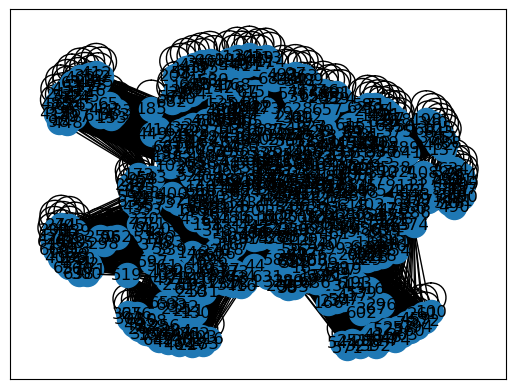

In [240]:
nx.draw_networkx(ngraph)